## Machine Learning 
## Rock Paper Scissors example

In [1]:
# All the needed imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
import glob
from PIL import Image
import numpy as np
import os

import torch.nn.functional as F
from torchvision import transforms
import torchvision



# Paper = 0, Rock = 1, Scissors = 2

In [2]:
class CustomDatasetFromFile(Dataset):
    def __init__(self, folder_path, transform=None):
        """
        A dataset example where the class is embedded in the file names
        This data example also does not use any torch transforms

        Args:
            folder_path (string): path to image folder
        """
        # Get image list
        self.image_list = glob.glob(folder_path+'*/*/*')
        # Calculate len
        self.data_len = len(self.image_list)
        # Set up transform
        self.transform = transform

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_path = self.image_list[index]
        # Open image
        img = Image.open(single_image_path)

        if self.transform is not None:
            img = self.transform(img)
        
        """
        # Do some operations on image
        # Convert to numpy, dim = 28x28
        im_as_np = np.asarray(im_as_im)/255
        # Add channel dimension, dim = 1x28x28
        # Note: You do not need to do this if you are reading RGB images
        # or i there is already channel dimension
        im_as_np = np.expand_dims(im_as_np, 0)
        # Some preprocessing operations on numpy array
        # ...
        # ...
        # ...

        # Transform image to tensor, change data type
        im_as_ten = torch.from_numpy(im_as_np).float()
        """
        
        # Get label(class) of the image based on the file name
        #class_indicator_location = single_image_path.rfind('_c')
        class_indicator_location = os.path.basename(os.path.dirname(single_image_path))
        if class_indicator_location == "rock":
            label = 1
        elif class_indicator_location == "scissors":
            label = 2
        else:
            label = 0
        return (img, label)

    def __len__(self):
        return self.data_len

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=.5, std=0.5)])


In [4]:
custom_data_train = CustomDatasetFromFile(r"./pastdata/training", transform)
custom_data_test = CustomDatasetFromFile(r"./pastdata/testing", transform)

#training_data = CustomDatasetFromFile(r"C:\Users\Sylvia Chen\Lab4\data\P2\training2")
#test_data = CustomDatasetFromFile(r"C:\Users\Sylvia Chen\Lab4\data\P2\testing2")

In [5]:
# Create data loaders.

batch_size = 64

trainloader = DataLoader(custom_data_train, batch_size=batch_size, shuffle=True)
testloader = DataLoader(custom_data_test, batch_size=batch_size, shuffle=True)

#print(len(test_dataloader))

for X, y in testloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


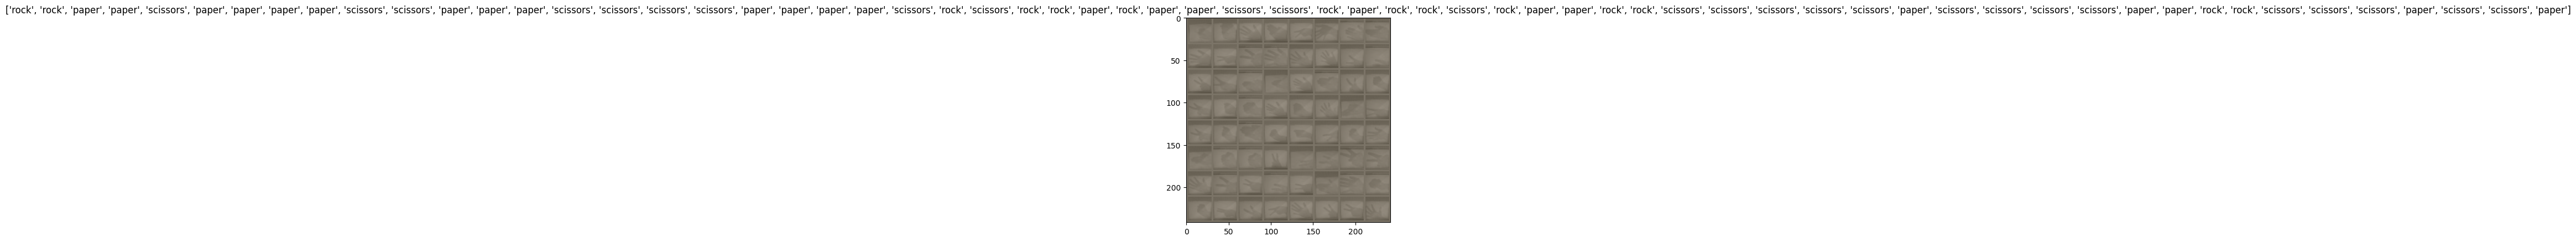

In [6]:
class_names = [
    "paper",
    "rock",
    "scissors",
]

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(trainloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes])

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define an NN model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(1568, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 3), #3
            #nn.ReLU(True),
            #nn.Dropout(),
            #nn.Linear(10, 3)
        )
        
        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(True))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(True))
        self.maxp1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(True))
        self.conv4 = nn.Sequential(nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(True))
        self.conv5 = nn.Sequential(nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(True))
        self.maxp2 = nn.MaxPool2d(2, 2)
        #self.aap1 = nn.AdaptiveAvgPool2d(7)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxp1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.maxp2(x)
        #x = self.aap1(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        #softmax = nn.Softmax(1)
        return logits #softmax(logits)

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1568, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [8]:
# Set the loss and optimizer to be used in the next next cell
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #, momentum=.5)

In [9]:
# The following two functions are used in the next cell.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    #print(size)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        #softmax = nn.Softmax(1)
        #pred = softmax(pred)
        #print(pred)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    #print(size)
    #print(num_batches)
    model.eval()
    test_loss, correct = 0, 0
    #count = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            #softmax = nn.Softmax(1)
            #pred = softmax(pred)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            #print(pred)
            print(pred.argmax(1))
            #print(y)
            #print(correct)
            #count += 1
            #print(count)
    test_loss /= num_batches
    correct /= size
    #print(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
# Training the NN model 
epochs = 10   #starting with 5 epochs --> may need to adjust
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(testloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.102513  [    0/ 4860]
loss: 1.075815  [ 1280/ 4860]
loss: 1.067273  [ 2560/ 4860]
loss: 1.067078  [ 3840/ 4860]
tensor([0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2,
        0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 2], device='cuda:0')
tensor([0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 2, 0, 0, 2, 2, 1, 0, 2,
        2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0], device='cuda:0')
tensor([2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2,
        0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0,
        2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0], device='cuda:0')
tensor([2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0,

In [11]:
# Saving the model in a file, we will use it in the next cell
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [12]:
# Using the model for some testing
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

classes = [
    "paper",
    "rock",
    "scissors",
]

model.eval()
x, y = custom_data_test[100][0], custom_data_test[100][1]

print(x.unsqueeze(1).shape)
with torch.no_grad():
    pred = model(x.unsqueeze(0))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

torch.Size([1, 1, 28, 28])
Predicted: "rock", Actual: "rock"


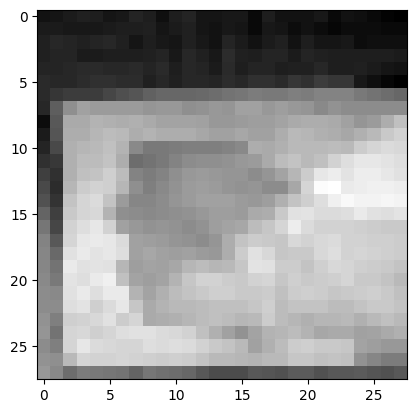

In [13]:
# Let's plot a few of the test images we used in the previous cell

plt.imshow(custom_data_test[100][0].squeeze(), cmap = "gray")

#try more visualization here